# <p style="text-align: center;"> Social Butterfly - Umbrella Academy - Sentiment Analysis </p>

![title](Sentiment_Analysis.png)

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# <p style="text-align: center;"> Table of Contents </p>
- ## 1. [Introduction](#Introduction)
   - ### 1.1 [Abstract](#abstract)
   - ### 1.2 [Importing Libraries](#importing_libraries)
   - ### 1.3 [Settings for Sentiment Analysis](#Settings_for_Sentiment)
   - ### 1.4 [Stream Listener](#Stream_Listener)
   - ### 1.5 [Dataset Summary](#dataset_summary)
   - ### 1.6 [Dataset Cleaning](#dataset_cleaning)
- ## 2. [Sentiment Distribution](#Sentiment_Distribution)
   - ### 2.1 [Tokenization](#Tokenization)
   - ### 2.2 [Stemming](#Stemming)
- ## 3. [LSTM](#lstm)
   - ### 3.1 [Creating character/word mappings](#char_and_word_mapping)
- ## 9. [Conclusion](#Conclusion)
- ## 10. [Contribution](#Contribution)
- ## 11. [Citation](#Citation)
- ## 12. [License](#License)

# <p style="text-align: center;"> 1.0 Introduction </p> <a id='Introduction'></a>

# 1.1 Abstract <a id='abstract'></a>

In the previous notebook we applied the lstm model on our dataset.(go to the [Link](After_Metadata_Git.ipynb) if you haven't seen it yet). 

[Back to top](#Introduction)

# 1.2 Importing Libraries <a id='importing_libraries'></a>

In this step, we import libraries that we need for this notebook. A few basic libraries like numpy, pandas, matplotlib etc are used. Other libraries like tweepy, json, csv are used to collect data from twitter and save them as a json and csv file. Libraries like base

[Back to top](#Introduction)

In [27]:
#Basic Python arrays and dataframe
import numpy as np
import pandas as pd

#Plotting and visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

#WordCloud
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator

#twitter api
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
   
#time based and os dependent functionality
import time
import os

# Utility
from collections import Counter
import logging
import seaborn as sns
import pickle
import itertools

#Plotly graphs
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks as cf

#regex string commands 
import re,string

#Data Extraction and saving
import json
import tweepy
import csv

#To encode and decode strings
import codecs

#Ignore warnings in outputs
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

#Twitter Credentials
twitter_cred = dict()

twitter_cred['CONSUMER_KEY'] = '2eKSRZ4rCtvI0P530zEmjEeIE'
twitter_cred['CONSUMER_SECRET'] = 'OUVG2jcIjRRuVvJ053RRuwPyAKxt9QXGz7GeKh35V24RsfO5Ep'
twitter_cred['ACCESS_KEY'] = '1392379572-rAHYsSNQCfEmcQndKMBqtIsp018Tb95mz1E9Jyy'
twitter_cred['ACCESS_SECRET'] = 'esUTGAcsgNhHPcEE3qwQd2Y6yL1sun3baRx02YmrUy83z'

In [4]:
with open('twitter_credentials.json', 'w') as secret_info:
    json.dump(twitter_cred, secret_info, indent=4, sort_keys=True)

In [5]:
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rushabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1.3 Settings for Sentiment Analysis<a id='Settings_for_Sentiment'></a>

[Back to top](#Introduction)

In [7]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "utf-8"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

Dataset details

>target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

>ids: The id of the tweet ( 2087)

>date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

>flag: The query (lyx). If there is no query, then this value is NO_QUERY.

>user: the user that tweeted (robotickilldozr)

>text: the text of the tweet (Lyx is cool)

# 1.4 Stream Listener<a id='Stream_Listener'></a>

Setting up the Stream Listener for Twitter Sentiment Analysis.

[Back to top](#Introduction)

In [8]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [9]:
df = pd.DataFrame(columns = ['Tweets', 'User', 'User_statuses_count', 
                             'user_followers', 'User_location', 'User_verified',
                             'fav_count', 'rt_count', 'tweet_date'])

In [17]:
def stream(data, file_name):
    i = 0
    for tweet in tweepy.Cursor(api.search, q=data, count=100, lang='en').items():
        print(i, end='\r')
        df.loc[i, 'Tweets'] = tweet.text
        df.loc[i, 'User'] = tweet.user.name
        df.loc[i, 'User_statuses_count'] = tweet.user.statuses_count
        df.loc[i, 'user_followers'] = tweet.user.followers_count
        df.loc[i, 'User_location'] = tweet.user.location
        df.loc[i, 'User_verified'] = tweet.user.verified
        df.loc[i, 'fav_count'] = tweet.favorite_count
        df.loc[i, 'rt_count'] = tweet.retweet_count
        df.loc[i, 'tweet_date'] = tweet.created_at
        df.to_excel('{}.xlsx'.format(file_name))
        i+=1
        if i == 1000:
            break
        else:
            pass

In [18]:
stream(data = ['AI'], file_name = 'tweets_sentiment')

# 1.5 Dataset Summary <a id='dataset_summary'></a>

Since this dataset is scraped from twitter, it is bound to have some irregular values. In this step we check the summary of the dataset by checking the first 5 columns of the scraped data, checking the data types of the columns and checking the mathematical summary of the dataset

[Back to top](#Introduction)

In [19]:
df.head()

,Tweets,User,User_statuses_count,user_followers,User_location,User_verified,fav_count,rt_count,tweet_date
0,RT @Utsava4: Violation of privacy for Zuckerbe...,Enlightened,1732,24,,False,0,2,2019-04-25 07:53:11
1,Why You Need #AI for #SEO Success in 2019 http...,Saranya Rajesh,351,55,"Pondicherry, India",False,0,0,2019-04-25 07:53:10
2,@Osu16Bit Watching the Kitana AI try to do com...,Konqrr - MK11,1652,824,"Tooele, Utah",False,0,0,2019-04-25 07:53:10
3,RT @S_Galimberti: Global #Megatrends #Video: #...,TOP Startups USA,66968,1426,,False,0,9,2019-04-25 07:53:08
4,RT @flandqvist: #ldsv2019 Sustainable #Knowled...,HealthTechArena,10,21,"Lindholmen, Gothenburg, Sweden",False,0,1,2019-04-25 07:53:08


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
Tweets                 1000 non-null object
User                   1000 non-null object
User_statuses_count    1000 non-null object
user_followers         1000 non-null object
User_location          1000 non-null object
User_verified          1000 non-null object
fav_count              1000 non-null object
rt_count               1000 non-null object
tweet_date             1000 non-null object
dtypes: object(9)
memory usage: 118.1+ KB


In [21]:
df.describe()

,Tweets,User,User_statuses_count,user_followers,User_location,User_verified,fav_count,rt_count,tweet_date
count,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,883,789,773,645,434,2,9,86,723
top,"RT @shininglive_en: (New 2/3) Snow falls, the ...",Machine Learning,151597,7034,,False,0,0,2019-04-25 07:30:00
freq,11,32,16,16,210,979,867,479,5


# 1.6 Dataset Cleaning <a id='dataset_cleaning'></a>
Since this dataset is scraped from twitter, it is bound to have some irregular values. By seeing the summary of our dataset we have gained some important insight about the type of data, and we need to clean the data to be able to further process it.

[Back to top](#Introduction)

In [28]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity ==0:
        return 'Neutral'
    else:
        return 'Negative'
    

In [29]:
# remove twitter handles (@user)
df['clean_tweet'] = np.vectorize(remove_pattern)(df['Tweets'], "@[\w]*")
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df['Sentiment'] = df['clean_tweet'].apply(lambda x: analyze_sentiment(x))

In [30]:
#printing particular tweet
n=20
print('Original tweet:\n'+ df['Tweets'][n])
print('Clean tweet:\n'+df['clean_tweet'][n])
print('Sentiment:\n'+df['Sentiment'][n])

Original tweet:
I need to draw them interacting but I still haven't decided how I want Ai to look
Clean tweet:
need draw them interacting still haven decided want look
Sentiment:
Neutral


# <p style="text-align: center;"> 2.0 Sentiment Distribution </p> <a id='Sentiment_Distribution'></a>

[Back to top](#Introduction)

In [31]:

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


In [32]:
df['Sentiment'].value_counts().iplot(kind='bar', xTitle='Sentiment',
                                    yTitle='Count', title='Overall Sentiment Distribution')

In [33]:
df_popular = df[df['rt_count'] >= 100]
df_popular['Sentiment'].value_counts().iplot(kind='bar', xTitle='Sentiment',
                                    yTitle='Count', title = 'Sentiment Distribution for <br> popular tweets (Above 100)')


In [34]:
df_unpopular = df[df['rt_count'] <= 100]
df_unpopular['Sentiment'].value_counts().iplot(kind='bar', xTitle='Sentiment',
                                    yTitle='Count', title = ('Sentiment Distribution for <br> unpopular tweets '))


In [35]:
#correlation between Tweeting Frequency and Followers
#Plot the number of statuses per user vs. number of followers per user.
#Differentiate between verified and non-verified users in our plot.

df.iplot(x='User_statuses_count', y = 'user_followers', mode='markers'
        , categories='User_verified',layout=dict(
        xaxis=dict(type='log', title='No. of Statuses'),
        yaxis=dict(type='log', title='No. of followers'),
        title='No. of statuses vs. No. of followers'))

# 2.1 Tokenization <a id='Tokenization'></a>

Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

[Back to top](#Sentiment_Distribution)

In [36]:
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Violation, privacy, Zuckerberg, over, selling...
1                         [Need, #SEO, Success, https]
2    [Watching, Kitana, combos, after, Toss, nerf, ...
3    [Global, #Megatrends, #Video, #EmergingMarkets...
4    [#ldsv, Sustainable, #KnowledgeGraphs, without...
Name: clean_tweet, dtype: object

# 2.2 Stemming <a id='Stemming'></a>

Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word. For example, For example – “play”, “player”, “played”, “plays” and “playing” are the different variations of the word – “play”.

[Back to top](#Sentiment_Distribution)


In [37]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [violat, privaci, zuckerberg, over, sell, data...
1                          [need, #seo, success, http]
2    [watch, kitana, combo, after, toss, nerf, doe,...
3    [global, #megatrend, #video, #emergingmarket, ...
4    [#ldsv, sustain, #knowledgegraph, without, #li...
Name: clean_tweet, dtype: object

In [46]:
#put tokens back together.
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

#df_cleans['Tokenized_tweets']= tokenized_tweet[i]

In [47]:
Stopwords_Updated = ('amp', 'gt', 'via' ,'de','https')

In [48]:
STOPWORDS=STOPWORDS.union(Stopwords_Updated)

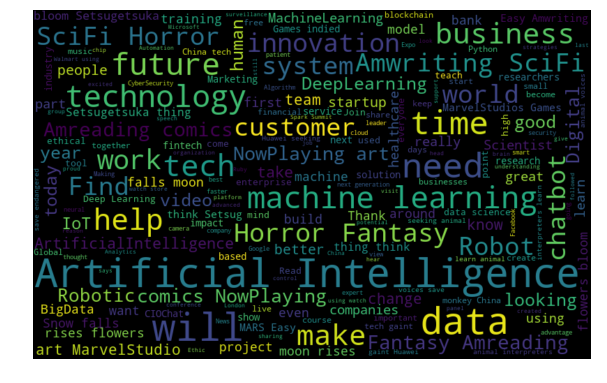

In [49]:
all_words = ' '.join([text for text in df['clean_tweet']])

wordcloud = WordCloud(width=800, height=500, stopwords=STOPWORDS,random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [50]:
df['sentiment_label'] = df['Sentiment'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

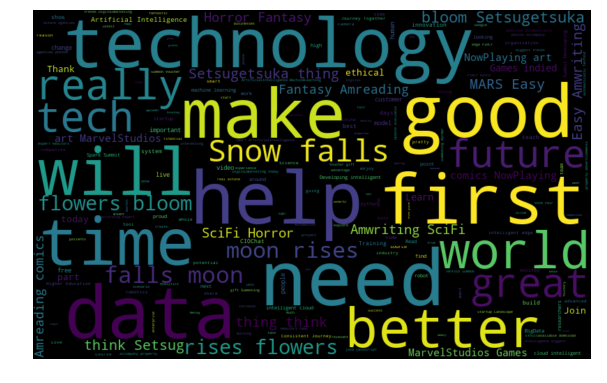

In [51]:
normal_words =' '.join([text for text in df['clean_tweet'][df['sentiment_label'] == 2]])

wordcloud = WordCloud(width=800, height=500, stopwords=STOPWORDS,random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

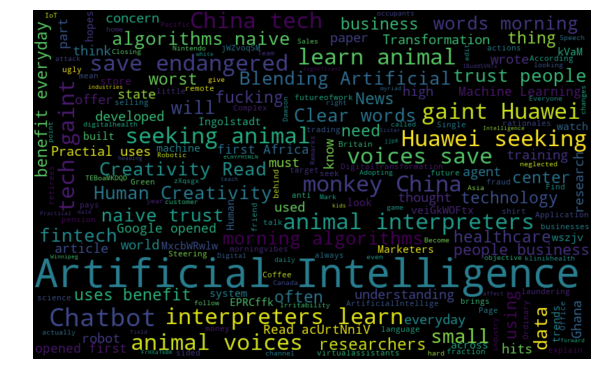

In [52]:
normal_words =' '.join([text for text in df['clean_tweet'][df['sentiment_label'] == 0]])

wordcloud = WordCloud(width=800, height=500, stopwords=STOPWORDS,random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# <p style="text-align: center;">3.0 Conclusion<p><a id='Conclusion'></a>
DataScience, AI, ML were the hashtags that we put in for scraping
As we can see from the graph above AI, ML, machinelearning, bigdata were the
    
[Back to top](#Introduction)

# <p style="text-align: center;">4.0 Contribution<p><a id='Contribution'></a>

    
- Code by self : 55%
- Code from external Sources : 45%

[Back to top](#Introduction)

# <p style="text-align: center;"> 5.0 Citations:<p><a id='Citation'></a>
1. https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/code/preprocess.py
2. https://stackoverflow.com/questions/8282553/removing-character-in-list-of-strings
3. https://github.com/bear/python-twitter/blob/master/twitter/parse_tweet.py
4. https://gist.github.com/dreikanter/2787146
5. https://docs.python.org/3.4/howto/unicode.html
6. https://www.kaggle.com/eliasdabbas/extract-entities-from-social-media-posts

[Back to top](#Introduction)

# <p style="text-align: center;"> 6.0 License<p><a id='License'></a>
Copyright (c) 2019 Rushabh Nisher, Manali Sharma

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

[Back to top](#Introduction)